# The `opencadd.databases.klifs` module

The `opencadd.databases.klifs` module offers to interact with KLIFS data 

- __locally__ ([KLIFS data download](https://klifs.net/search.php)) and
- __remote__ ([KLIFS swagger API (beta)](https://klifs.net/swagger_v2/))  

following the same API in its `local` and `remote` modules.

In the following, the API will be demonstrated in parallel for local and remote access for the following sources of information (classes in `local` and `remote` modules):

- `Kinases`: Details on kinases in KLIFS
- `Ligands`: Details on ligands in KLIFS
- `Structures`  Details on structures in KLIFS (extracted from the PDB)
- `Bioactivities` (accessible only remotely): Details on bioactivities in KLIFS (extracted from ChEMBL)
- `Interactions`: Details on kinase-ligand interactions in KLIFS
- `Pockets`: Details on kinase pockets in KLIFS
- `Coordinates`: Coordinates for complexes, ligands, pockets, proteins, and water in KLIFS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from pathlib import Path

from bravado_core.exception import SwaggerMappingError
import pandas as pd
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', 50)
logger = logging.getLogger("opencadd")
logger.setLevel(logging.INFO)

## Set up remote and local session

From the `api` module, import the session setup functions `setup_remote()` and `setup_local()`.

In [4]:
from opencadd.databases.klifs import setup_local, setup_remote

### Remote session

Set up a __remote session__ to work with remote KLIFS data (access via the KLIFS swagger API).

In [5]:
remote = setup_remote()

In [6]:
remote._client

SerializableSwaggerClient(https://dev.klifs.net/api_v2)

### Local session

Set up a __local session__ to work with local KLIFS data (access to a KLIFS download folder).

In [7]:
local = setup_local("../../opencadd/tests/data/klifs")

The `setup_local` function will initialize a __database__ (a `pandas.DataFrame`), describing the metadata of structures contained in the KLIFS download. 

In [8]:
local._database

,species.klifs,structure.pdb_id,structure.alternate_model,structure.chain,ligand.expo_id,ligand_allosteric.expo_id,structure.rmsd1,structure.rmsd2,structure.qualityscore,structure.pocket,structure.resolution,structure.missing_residues,structure.missing_atoms,interaction.fingerprint,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,kinase.names,kinase.gene_name,kinase.klifs_name,kinase.family,kinase.group,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.filepath,structure.klifs_id,kinase.klifs_id
0,Human,3sxr,-,A,1N1,-,0.839,1.967,6.4,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,2.40,4,0,0000000000000010000001000000000000000000000000...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[BMX],BMX,BMX,Tec,TK,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,HUMAN/BMX/3sxr_chainA,3482,472
1,Human,6uuo,-,A,QH1,-,0.806,2.028,5.2,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,3.29,7,61,0000000000000000000000000000000000000000000000...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,[BRAF],BRAF,BRAF,RAF,TKL,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,HUMAN/BRAF/6uuo_chainA,12347,509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Human,7lht,-,A,-,ATP,10.267,15.045,4.0,KALGKGLFSMVIRITLKVVGLRILNLPHLILEYCKAKDIIRFLQQK...,3.50,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[LRRK2],LRRK2,LRRK2,LRRK,TKL,-,ADENOSINE-5&apos;-TRIPHOSPHATE,out,out,HUMAN/LRRK2/7lht_chainA,13623,495
5,Human,2ogv,-,A,-,-,1.043,2.362,6.4,KTLGAGAFGKVVEVAVKMLALMSELKIMSHLGENIVNLLGALVITE...,2.70,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[CSF1R, FMS]",CSF1R,FMS,PDGFR,TK,-,-,out,in,HUMAN/FMS/2ogv_chainA,1243,449


### Access information

Different sources of information are accessible via (instances of classes introduced earlier, which are initialized upon session setup):

- `local.kinases` or `remote.kinases`
- `local.ligands` or `remote.ligands`
- `local.structures` or `remote.structures`
- `local.bioactivities` or `remote.bioactivities`
- `local.interactions` or `remote.interactions`
- `local.pockets` or `remote.pockets`
- `remote.drugs` (not available locally)
- `local.coordinates` or `remote.coordinates` (check more details in the "Coordinates" section of this notebook)

|                           | kinases | ligands | structures | bioactivities | interactions | pockets | drugs | conformations | modified residues |
|:--------------------------| ------- | ------- | ---------- | ------------- | ------------ | ------- | ----- | ------------- | ----------------- |
| __by_kinase_klifs_id__    | x       | x       | x          | x             | x            |         |       |               |                   |
| __by_kinase_name__        | x       | x       | x          |               |              |         |       |               |                   |
| __by_ligand_klifs_id__    |         | x       | x          | x             | x            |         |       |               |                   |
| __by_ligand_expo_id__     |         | x       | x          | x             |              |         |       |               |                   |
| __by_structure_klifs_id__ |         |         | x          |               | x            | x       |       | x             | x                 |
| __by_structure_pdb_id__   |         |         | x          |               |              |         |       |               |                   |
| __all\_\*__               | x       | x       | x          | x             | x            |         | x     | x             |                   |

\* all_kinases, all_kinases_groups, all_kinase_families, all_ligands, all_structures, ...

## Kinases

Explore access to kinase information.

### All kinase groups

__Remote__

In [9]:
remote.kinases.all_kinase_groups()

,kinase.group
0,AGC
1,CAMK
...,...
6,TK
7,TKL


__Local__

__Note__: When querying all kinase groups locally, "all" refers to "all kinase groups that are locally available" and hence does not represent all existing kinase groups.

In [10]:
local.kinases.all_kinase_groups()

,kinase.group
0,TK
1,TKL


### All kinase families (in a kinase group)

__Remote__

In [11]:
remote.kinases.all_kinase_families()

,kinase.family
0,A6
1,ABC1
...,...
142,Wnk
143,YANK


In [12]:
remote.kinases.all_kinase_families(groups="TK")

,kinase.family
0,ALK
1,Abl
...,...
29,Trk
30,VEGFR


In [13]:
try:
    remote.kinases.all_kinase_families(groups="XXX")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: A provided group does not exist.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

__Note__: When querying all kinase families locally, "all" refers to "all kinase families that are locally available" and hence does not represent all existing kinase families.

In [14]:
local.kinases.all_kinase_families()

,kinase.family
0,Tec
1,RAF
2,Abl
3,LRRK
4,PDGFR


In [15]:
local.kinases.all_kinase_families(groups="TK")

,kinase.family
0,Tec
1,Abl
2,PDGFR


In [16]:
try:
    local.kinases.all_kinase_families("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### All kinase names

__Remote__

In [17]:
remote.kinases.all_kinases()

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,529,A6,0,,0,Mouse
1,530,A6r,0,,0,Mouse
...,...,...,...,...,...,...
1125,1062,ZAP70,zeta-chain (TCR) associated protein kinase,Zap70,P43404,Mouse
1126,471,ZAP70,zeta chain of T cell receptor associated prote...,ZAP70,P43403,Human


In [18]:
remote.kinases.all_kinases(groups="TK", families="Tec", species="Mouse")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,574,BMX,BMX non-receptor tyrosine kinase,Bmx,P97504,Mouse
1,583,BTK,Bruton agammaglobulinemia tyrosine kinase,Btk,P35991,Mouse
2,739,ITK,IL2 inducible T cell kinase,Itk,Q03526,Mouse
3,1008,TEC,tec protein tyrosine kinase,Tec,P24604,Mouse
4,1039,TXK,TXK tyrosine kinase,Txk,P42682,Mouse


In [19]:
try:
    remote.kinases.all_kinases(groups="XXX")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: A provided group does not exist.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

__Note__: When querying all kinase names locally, "all" refers to "all kinase names that are locally available" and hence does not represent all existing kinase names.

In [20]:
local.kinases.all_kinases(families="Tec")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,472,BMX,<NA>,BMX,<NA>,Human


In [21]:
local.kinases.all_kinases(families="Abl", species="Mouse")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.uniprot,species.klifs
0,532,ABL1,<NA>,Abl1,<NA>,Mouse


In [22]:
try:
    local.kinases.all_kinases(groups="XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Kinase by kinase KLIFS ID

__Remote__

In [23]:
remote.kinases.by_kinase_klifs_id(1)

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,1,AKT1,v-akt murine thymoma viral oncogene homolog 1,AKT1,Akt,AGC,,Human,P31749,1479,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...


In [24]:
remote.kinases.by_kinase_klifs_id([1,2,10000])

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,1,AKT1,v-akt murine thymoma viral oncogene homolog 1,AKT1,Akt,AGC,,Human,P31749,1479,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...
1,2,AKT2,v-akt murine thymoma viral oncogene homolog 2,AKT2,Akt,AGC,,Human,P31751,1480,KLLGKGTFGKVILYAMKILHTVTESRVLQNTRPFLTALKYACFVME...


In [25]:
try:
    remote.kinases.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [26]:
local.kinases.by_kinase_klifs_id(472)

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,<NA>,BMX,Tec,TK,<NA>,Human,<NA>,<NA>,<NA>


In [27]:
local.kinases.by_kinase_klifs_id([472, 509, 10000])

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,<NA>,BMX,Tec,TK,<NA>,Human,<NA>,<NA>,<NA>
1,509,BRAF,<NA>,BRAF,RAF,TKL,<NA>,Human,<NA>,<NA>,<NA>


In [28]:
try:
    local.kinases.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


### Kinase by kinase name (and species)

__Remote__

In [29]:
remote.kinases.by_kinase_name("BMX")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,574,BMX,BMX non-receptor tyrosine kinase,Bmx,Tec,TK,,Mouse,P97504,0,KELGNGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,472,BMX,BMX non-receptor tyrosine kinase,BMX,Tec,TK,,Human,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


In [30]:
remote.kinases.by_kinase_name("Bmx")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,574,BMX,BMX non-receptor tyrosine kinase,Bmx,Tec,TK,,Mouse,P97504,0,KELGNGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...
1,472,BMX,BMX non-receptor tyrosine kinase,BMX,Tec,TK,,Human,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


In [31]:
try:
    remote.kinases.by_kinase_name("BMX", species="Dog")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: The provided species does not exist. '] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


In [32]:
remote.kinases.by_kinase_name(["BMX", "BRAF", "XXX"], species="Human")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,509,BRAF,"B-Raf proto-oncogene, serine/threonine kinase",BRAF,RAF,TKL,RAF,Human,P15056,1943,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...
1,472,BMX,BMX non-receptor tyrosine kinase,BMX,Tec,TK,,Human,P51813,1942,KELGSGQFGVVQLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...


__Local__

In [33]:
local.kinases.by_kinase_name("BMX")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,<NA>,BMX,Tec,TK,<NA>,Human,<NA>,<NA>,<NA>


In [34]:
try:
    local.kinases.by_kinase_name("BMX", species="Dog")
except ValueError as e:
    print(e)

Input values yield no results.


In [35]:
local.kinases.by_kinase_name(["BMX", "BRAF", "XXX"], species="Human")

,kinase.klifs_id,kinase.klifs_name,kinase.full_name,kinase.gene_name,kinase.family,kinase.group,kinase.subfamily,species.klifs,kinase.uniprot,kinase.iuphar,kinase.pocket
0,472,BMX,<NA>,BMX,Tec,TK,<NA>,Human,<NA>,<NA>,<NA>
1,509,BRAF,<NA>,BRAF,RAF,TKL,<NA>,Human,<NA>,<NA>,<NA>


## Ligands

Explore access to ligand information.

### All ligands

__Remote__

In [36]:
remote.ligands.all_ligands()

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,1,IHZ,5-[(2-methyl-5-{[3-(trifluoromethyl)phenyl]car...,FC(F)(F)c1cc(NC(=O)c2cc(Nc3cncc(c3)C(=O)N)c(cc...,SAAYRHKJHDIDPH-UHFFFAOYSA-N
1,2,477,"3-{2-[5-(difluoromethyl)-2H-thieno[3,2-c]pyraz...",S1C=2C(=NNC2C=C1C(F)F)C=3Nc4c(ccc(c4)C(O)(CC)C...,CQZZZUNOWZUNNG-UHFFFAOYSA-N
...,...,...,...,...,...
3810,4099,0CI,5-(1-{[(3S)-1-propanoylpyrrolidin-3-yl]oxy}iso...,CCC(=O)N1CC[C@@H](C1)Oc2c3ccccc3cc(n2)C4=NNC(=...,HTXPJYDZXSMZTC-LBPRGKRZSA-N
3811,4100,VK5,~{N}-[[3-[4-[(dimethylamino)methyl]phenyl]imid...,Cc1cc(cnc1c2nnc(o2)N(C)Cc3ccc4ncc(n4c3)c5ccc(c...,CZIXXCVLEHVEBZ-UHFFFAOYSA-N


__Local__

__Note__: When querying all ligands locally, "all" refers to "all ligands that are locally available" and hence does not represent all existing ligands.

In [37]:
local.ligands.all_ligands()

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,<NA>,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,<NA>,<NA>
1,<NA>,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,<NA>,<NA>
2,<NA>,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,<NA>,<NA>
3,<NA>,-,-,<NA>,<NA>


Locally, information on SMILES and InChI keys is not available. Also no ligand ID, but maybe the KLIFS maintainers can change that?

### Ligands from kinase KLIFS ID(s)

__Remote__

In [38]:
remote.ligands.by_kinase_klifs_id(472)

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472
2,3716,H88,~{N}-[2-methyl-5-[8-[4-(methylsulfonylamino)ph...,S(=O)(=O)(Nc1ccc(c2cc3ncc4c(N(c5cc(NC(=O)CCO)c...,InChI not available,472


In [39]:
remote.ligands.by_kinase_klifs_id([472, 509, 10000])

Processing...:   0%|          | 0/3 [00:00<?, ?it/s]

There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472
...,...,...,...,...,...,...
68,4028,VQP,"N-(3,3-dimethylbutyl)-N&#039;-{2-fluoro-5-[(5-...",Fc1c(Nc2c(cc(F)c(NC(=O)NCCC(C)(C)C)c2)C)ccc3N=...,InChI not available,509
69,4029,V5J,3-(2-cyanopropan-2-yl)-N-[2-fluoro-4-methyl-5-...,Fc1c(NC(=O)c2cc(ccc2)C(C#N)(C)C)cc(c3cnc4c(c3)...,InChI not available,509


In [40]:
try:
    remote.ligands.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

In [41]:
local.ligands.by_kinase_klifs_id(472)

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,<NA>,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,<NA>,<NA>,472


In [42]:
local.ligands.by_kinase_klifs_id([472, 509, 10000])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query)
0,<NA>,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,<NA>,<NA>,472
1,<NA>,QH1,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,<NA>,<NA>,509


In [43]:
try:
    local.ligands.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


### Ligands from kinase name(s)

__Remote__

In [44]:
remote.ligands.by_kinase_name(["ABL1", "BMX"])

Processing...:   0%|          | 0/4 [00:00<?, ?it/s]

There was (were) 1/4 failed request(s).
Show error messages (up to 5 messages only):
Error for 574: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_id (query),kinase.klifs_name (query),kinase.gene_name (query),species.klifs (query)
0,281,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,Clc1c(NC(=O)C=2SC(=NC2)Nc3nc(nc(N4CCN(CCO)CC4)...,ZBNZXTGUTAYRHI-UHFFFAOYSA-N,472,BMX,BMX,Human
1,632,PP2,1-TERT-BUTYL-3-(4-CHLORO-PHENYL)-1H-PYRAZOLO[3...,Clc1ccc(cc1)C2=[NH+]N(c3ncnc(N)c32)C(C)(C)C,PBBRWFOVCUAONR-UHFFFAOYSA-O,472,BMX,BMX,Human
...,...,...,...,...,...,...,...,...,...
45,3247,FYH,3-(morpholin-4-ylmethyl)-~{N}-[4-(trifluoromet...,FC(F)(F)Oc1ccc(NC(=O)c2cc(ccc2)CN3CCOCC3)cc1,MYWULUKAXYAFSH-UHFFFAOYSA-N,532,ABL1,Abl1,Mouse
46,3255,FYW,6-[(3~{R})-3-oxidanylpyrrolidin-1-yl]-5-pyrimi...,c1cc(ccc1NC(=O)c2cc(c(nc2)N3CC[C@H](C3)O)c4cnc...,LARFZNXVNANWFD-MRXNPFEDSA-N,532,ABL1,Abl1,Mouse


In [45]:
try:
    remote.ligands.by_kinase_name("XXX")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase name was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [46]:
local.ligands.by_kinase_name(["ABL1", "BMX"])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey,kinase.klifs_name (query),kinase.gene_name (query),species.klifs (query)
0,<NA>,1N1,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,<NA>,<NA>,BMX,BMX,Human
1,<NA>,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,<NA>,<NA>,ABL1,Abl1,Mouse


In [47]:
try:
    local.ligands.by_kinase_name("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Ligands from ligand KLIFS ID(s)

__Remote__

In [48]:
remote.ligands.by_ligand_klifs_id([100, 200, 10000])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,100,KSA,K-252A,O=C(OC)[C@]1(O)[C@@]2(O[C@@H](N3c4c5N2c6c(c5c7...,KOZFSFOOLUUIGY-SOLYNIJKSA-N
1,200,TSK,3-(5-fluoro-6-iodo-1-methyl-1H-indol-3-yl)-4-(...,Ic1c(F)cc2c(N(C=C2C=3C(=O)NC(=O)C3C=4c5c(OC4)c...,JBKILIGSDAQHSL-UHFFFAOYSA-N


In [49]:
try:
    remote.ligands.by_ligand_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Ligands from ligand expo ID(s)

__Remote__

In [50]:
remote.ligands.by_ligand_expo_id(["STI", "STU", "XXX"])

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,28,STU,STAUROSPORINE,O=C1NCc2c3c4N(c5c3cccc5)[C@]6(O[C@@H](N7c4c(c8...,HKSZLNNOFSGOKW-FYTWVXJKSA-N
1,48,STI,4-(4-METHYL-PIPERAZIN-1-YLMETHYL)-N-[4-METHYL-...,O=C(Nc1cc(Nc2nc(c3cnccc3)ccn2)c(cc1)C)c4ccc(cc...,KTUFNOKKBVMGRW-UHFFFAOYSA-N


In [51]:
try:
    remote.ligands.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [52]:
local.ligands.by_ligand_expo_id(["STI", "STU", "PRC"])  # TODO why do STI STU work but XXX does not?

,ligand.klifs_id,ligand.expo_id,ligand.name,ligand.smiles,ligand.inchikey
0,<NA>,PRC,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,<NA>,<NA>


In [53]:
try:
    local.ligands.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


## Drugs

KLIFS also provides a list of approved drugs:

> The drug list endpoint returns a list of all annotated kinase ligands that are either approved or are/have been in clinical trials. This information is primarily powered by the PKIDB and complemented with KLIFS curation and annotation + manually curated data from other sources (e.g. approved INNs).

https://dev.klifs.net/swagger_v2/#/Ligands/get_drug_list

__Note__: Only available remotely (not locally).

### All drugs

__Remote__

In [54]:
remote.drugs.all_drugs()

,drug.inn,drug.brand_name,drug.synonym,drug.phase,drug.approval_year,drug.smiles,ligand.chembl_id,ligand.expo_id
0,Abemaciclib,"['Verzenio', 'Verzenios']",ABEMACICLIB LY-2835219 LY2835219 VERZENIO VERZ...,4,2017,CCN1CCN(CC1)Cc2ccc(nc2)Nc3ncc(c(n3)c4cc5c(c(c4...,CHEMBL3301610,6ZV
1,Abivertinib,[],A610 ABIVERTINIB AC-0010 AC0010 ACEA100610 AVI...,3,,CN1CCN(CC1)c2ccc(cc2F)Nc3nc4c(cc[nH]4)c(n3)Oc5...,CHEMBL4297865,
...,...,...,...,...,...,...,...,...
422,Bezuclastinib,[],PLX9486 CGT 9486,2,,Cc1c([nH]nc1C(=O)Nc2cc3cc([nH]c3nc2)c4ccccc4)C,,WEJ
423,Belumosudil,['Rezurock'],KD025 SLx2119,4,2021,CC(NC(=O)COc1cccc(c1)c1nc(Nc2ccc3c(c2)cn[nH]3)...,CHEMBL2005186,


## Bioactivities

Explore access to bioactivity information.

### All bioactivities

__Remote__

In [55]:
# Takes a couple of minutes for all ligands, thus use only top 50 as show case here
bioactivities_all = remote.bioactivities.all_bioactivities(_top_n=10)
bioactivities_all

Processing...:   0%|          | 0/10 [00:00<?, ?it/s]

,kinase.pref_name,kinase.uniprot,kinase.chembl_id,ligand.chembl_id,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl
0,Discoidin domain-containing receptor 2,Q16832,CHEMBL5122,CHEMBL552425,IC50,=,18.60,nM,7.73,Homo sapiens
1,Ephrin type-B receptor 2,P29323,CHEMBL3290,CHEMBL552425,EC50,=,40.00,nM,7.40,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...
540,Tyrosine-protein kinase LCK,P06239,CHEMBL258,CHEMBL3086536,Ki,=,55.00,nM,7.26,Homo sapiens
541,Tyrosine-protein kinase ITK/TSK,Q08881,CHEMBL2959,CHEMBL3263052,Ki,=,0.93,nM,9.03,Homo sapiens


__Local__

This information is not available locally.

### Bioactivities from kinase KLIFS ID(s)

__Remote__

In [56]:
remote.bioactivities.by_kinase_klifs_id([472, 10000])

Processing...:   0%|          | 0/2 [00:00<?, ?it/s]

There was (were) 1/2 failed request(s).
Show error messages (up to 5 messages only):
Error for 10000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Processing...:   0%|          | 0/3 [00:00<?, ?it/s]

There was (were) 2/3 failed request(s).
Show error messages (up to 5 messages only):
Error for 632: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.
Error for 3716: Expected type to be dict for value [400, 'KLIFS error: This ligand is not available in ChEMBL.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.pref_name,kinase.uniprot,kinase.chembl_id,ligand.chembl_id,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl
0,Activin receptor type-1,Q04771,CHEMBL5903,CHEMBL1421,Kd,=,620.00,nM,6.21,Homo sapiens
1,Activin receptor type-1,Q04771,CHEMBL5903,CHEMBL1421,Ki,=,79.43,nM,7.10,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...
289,Wee1-like protein kinase 2,P0C1S8,CHEMBL5095,CHEMBL1421,Kd,=,200.00,nM,6.70,Homo sapiens
290,Wee1-like protein kinase 2,P0C1S8,CHEMBL5095,CHEMBL1421,Kd,=,481.00,nM,6.32,Homo sapiens


In [57]:
try:
    remote.bioactivities.by_kinase_klifs_id(10000000)
except SwaggerMappingError as e:
    print(e)

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
Error for 10000000: Expected type to be dict for value [400, 'KLIFS error: The provided kinase ID(s) is/are invalid'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

This information is not available locally.

### Bioactivities from ligand KLIFS ID(s)

In [58]:
remote.bioactivities.by_ligand_klifs_id([100, 200, 10000])

Processing...:   0%|          | 0/3 [00:00<?, ?it/s]

There was (were) 1/3 failed request(s).
Show error messages (up to 5 messages only):
Error for 10000: Expected type to be dict for value [400, 'KLIFS error: Could not find a ligand with the provided ID.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


,kinase.pref_name,kinase.uniprot,kinase.chembl_id,ligand.chembl_id,ligand.bioactivity_standard_type,ligand.bioactivity_standard_relation,ligand.bioactivity_standard_value,ligand.bioactivity_standard_units,ligand.bioactivity_pchembl_value,species.chembl,ligand.klifs_id (query)
0,cAMP-dependent protein kinase alpha-catalytic ...,Q95J97,CHEMBL4885,CHEMBL281948,IC50,=,0.016,nM,10.80,Oryctolagus cuniculus,100
1,"Myosin light chain kinase, smooth muscle",P11799,CHEMBL3062,CHEMBL281948,IC50,=,0.020,nM,10.70,Gallus gallus,100
...,...,...,...,...,...,...,...,...,...,...,...
7,Vascular endothelial growth factor receptor 2,P35968,CHEMBL279,CHEMBL281948,IC50,=,43.000,nM,7.37,Homo sapiens,100
8,Glycogen synthase kinase-3 beta,P49841,CHEMBL262,CHEMBL523435,IC50,=,247.000,nM,6.61,Homo sapiens,200


In [59]:
try:
    remote.bioactivities.by_ligand_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

There was (were) 1/1 failed request(s).
Show error messages (up to 5 messages only):
Error for 10000: Expected type to be dict for value [400, 'KLIFS error: Could not find a ligand with the provided ID.'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


Input values yield no results.


__Local__

This information is not available locally.

## Structures

Explore access to structure information.

### All structures

__Remote__

In [60]:
remote.structures.all_structures()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,10970,6hhf,-,A,Human,1,AKT1,<NA>,<NA>,<NA>,KLLGKGTFGKVILYAMKIL___________SRPFLTALKYSCFVME...,G4K,-,3345,0,<NA>,<NA>,out,na,2.9,3.2,11,0,0.961,2.358,<NA>,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,20.223200,67.835503,55.009102,<NA>,False
1,10439,6buu,B,B,Human,1,AKT1,<NA>,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,-,-,0,0,<NA>,<NA>,in,in,2.4,8.0,0,0,0.776,2.091,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17.901100,59.594799,60.872501,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12570,9069,6bq1,-,E,Human,1096,PI4KA,<NA>,<NA>,<NA>,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,E4S,-,2974,0,<NA>,<NA>,out-like,in,NaN,6.8,2,0,1.699,2.670,<NA>,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,18.168600,58.645401,136.503006,<NA>,False
12571,9070,6bq1,-,A,Human,1096,PI4KA,<NA>,<NA>,<NA>,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,E4S,-,2974,0,<NA>,<NA>,out-like,in,NaN,6.8,2,0,1.704,2.676,<NA>,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,18.324301,58.963501,131.186996,<NA>,False


__Local__

__Note__: When querying all structures locally, "all" refers to "all structures that are locally available" and hence does not represent all existing structures.

In [61]:
local.structures.all_structures()

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,3482,3sxr,-,A,Human,472,BMX,['BMX'],Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,<NA>,<NA>,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.40,6.4,4,0,0.839,1.967,0000000000000010000001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BMX/3sxr_chainA,<NA>
1,12347,6uuo,-,A,Human,509,BRAF,['BRAF'],RAF,TKL,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,<NA>,<NA>,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,3.29,5.2,7,61,0.806,2.028,0000000000000000000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,True,True,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BRAF/6uuo_chainA,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,13623,7lht,-,A,Human,495,LRRK2,['LRRK2'],LRRK,TKL,KALGKGLFSMVIRITLKVVGLRILNLPHLILEYCKAKDIIRFLQQK...,-,ATP,<NA>,<NA>,-,ADENOSINE-5&apos;-TRIPHOSPHATE,out,out,3.50,4.0,0,0,10.267,15.045,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,HUMAN/LRRK2/7lht_chainA,<NA>
5,1243,2ogv,-,A,Human,449,FMS,"['CSF1R', 'FMS']",PDGFR,TK,KTLGAGAFGKVVEVAVKMLALMSELKIMSHLGENIVNLLGALVITE...,-,-,<NA>,<NA>,-,-,out,in,2.70,6.4,2,0,1.043,2.362,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,HUMAN/FMS/2ogv_chainA,<NA>


### Structures from structure KLIFS ID(s)

__Remote__

In [62]:
remote.structures.by_structure_klifs_id([12347, 100000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,12347,6uuo,-,A,Human,509,BRAF,<NA>,<NA>,<NA>,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,3715,0,<NA>,<NA>,in,out,3.29,5.2,7,61,0.806,2.028,<NA>,True,True,True,False,False,True,True,True,True,False,False,False,False,False,False,0.0,0.0,0.0,<NA>,False


In [63]:
try: 
    remote.structures.by_structure_klifs_id(100000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown structure ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [64]:
local.structures.by_structure_klifs_id(12347)

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,12347,6uuo,-,A,Human,509,BRAF,['BRAF'],RAF,TKL,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,<NA>,<NA>,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,3.29,5.2,7,61,0.806,2.028,0000000000000000000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,True,True,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BRAF/6uuo_chainA,<NA>


In [65]:
local.structures.by_structure_klifs_id(12347).shape

(1, 46)

In [66]:
try: 
    local.structures.by_structure_klifs_id(100000)
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from ligand KLIFS ID(s)

__Remote__

In [67]:
remote.structures.by_ligand_klifs_id([100, 200, 10000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,8735,5m5a,A,A,Human,128,MELK,<NA>,<NA>,<NA>,ETIGTGGFAKVKLVAIKIMRIKTEIEALKNLRQHICQLYHVFMVLE...,KSA,-,100,0,<NA>,<NA>,in,in,1.9,8.0,0,0,0.775,2.083,<NA>,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,14.9753,51.023800,60.378601,<NA>,False
1,8733,5m5a,B,A,Human,128,MELK,<NA>,<NA>,<NA>,ETIGTGGFAKVKLVAIKIMRIKTEIEALKNLRQHICQLYHVFMVLE...,KSA,-,100,0,<NA>,<NA>,in,in,1.9,8.0,0,0,0.775,2.083,<NA>,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,14.9753,51.023800,60.378601,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,3317,3eqf,-,A,Human,383,MAP2K1,<NA>,<NA>,<NA>,SELGAGNGGVVFKMARKLIQIIRELQVLHECNPYIVGFYGASICME...,KSA,-,100,0,<NA>,<NA>,in,out,2.7,8.0,0,0,0.816,2.199,<NA>,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,15.1080,51.288502,69.366898,<NA>,False
13,2991,1r0p,-,A,Human,446,MET,<NA>,<NA>,<NA>,EVIGRGHFGCVYHCAVKSLQFLTEGIIMKDFSPNVLSLLGILVVLP...,KSA,-,100,0,<NA>,<NA>,in,out,1.8,8.0,0,0,0.848,2.189,<NA>,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,20.0054,66.349403,48.160198,<NA>,False


In [68]:
try:
    remote.structures.by_ligand_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Structures from kinase KLIFS ID(s)

__Remote__

In [69]:
remote.structures.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,3483,3sxs,-,A,Human,472,BMX,<NA>,<NA>,<NA>,KELGSGQFGVVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,PP2,-,632,0,<NA>,<NA>,out-like,in,1.89,8.0,0,0,0.834,2.106,<NA>,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,15.3623,50.710098,62.744400,<NA>,False
1,3481,3sxr,-,B,Human,472,BMX,<NA>,<NA>,<NA>,KEL______VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,281,0,<NA>,<NA>,out-like,in,2.40,5.6,6,0,0.839,1.946,<NA>,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.0000,0.000000,0.000000,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,3126,4pp7,-,B,Human,509,BRAF,<NA>,<NA>,<NA>,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,2VX,-,945,0,<NA>,<NA>,in,out,3.40,8.0,0,0,0.813,2.142,<NA>,True,True,True,True,False,True,True,True,False,False,False,False,False,False,False,17.1234,55.548302,31.851000,<NA>,False
226,3095,3d4q,-,A,Human,509,BRAF,<NA>,<NA>,<NA>,QRIGSGSFGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,SM5,-,249,0,<NA>,<NA>,in,in,2.80,8.0,0,0,0.779,2.120,<NA>,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,14.7287,49.465599,72.604401,<NA>,False


In [70]:
try:
    remote.structures.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [71]:
local.structures.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,3482,3sxr,-,A,Human,472,BMX,['BMX'],Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,<NA>,<NA>,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.40,6.4,4,0,0.839,1.967,0000000000000010000001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BMX/3sxr_chainA,<NA>
1,12347,6uuo,-,A,Human,509,BRAF,['BRAF'],RAF,TKL,QRI____FGTVYKVAVKMLAFKNEVGVLRKTRVNILLFMGYAIVTQ...,QH1,-,<NA>,<NA>,1-[4-{[1-(3-{[dihydroxy(propyl)-lambda~4~-sulf...,-,in,out-like,3.29,5.2,7,61,0.806,2.028,0000000000000000000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,True,True,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BRAF/6uuo_chainA,<NA>


In [72]:
try:
    local.structures.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from structure PDB ID(s)

__Remote__

In [73]:
remote.structures.by_structure_pdb_id(["3sxr", "1fpu", "xxxx"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,5705,1fpu,-,B,Mouse,532,ABL1,<NA>,<NA>,<NA>,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,1793,0,<NA>,<NA>,out,in,2.4,9.2,0,4,0.925,2.329,<NA>,True,True,True,False,False,False,True,False,False,False,True,False,False,False,False,15.332900,51.093899,49.228901,<NA>,False
1,5728,1fpu,-,A,Mouse,532,ABL1,<NA>,<NA>,<NA>,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,1793,0,<NA>,<NA>,out,in,2.4,8.8,0,8,0.925,2.319,<NA>,True,True,True,False,False,True,True,False,False,False,True,False,False,False,False,16.155399,54.140202,48.741402,<NA>,False
2,3481,3sxr,-,B,Human,472,BMX,<NA>,<NA>,<NA>,KEL______VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,281,0,<NA>,<NA>,out-like,in,2.4,5.6,6,0,0.839,1.946,<NA>,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.000000,0.000000,0.000000,<NA>,False
3,3482,3sxr,-,A,Human,472,BMX,<NA>,<NA>,<NA>,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,281,0,<NA>,<NA>,out-like,in,2.4,6.4,4,0,0.839,1.967,<NA>,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,0.000000,0.000000,0.000000,<NA>,False


In [74]:
try:
    remote.structures.by_structure_pdb_id("xxxx")
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown PDB-code was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [75]:
local.structures.by_structure_pdb_id(["3sxr", "1fpu", "xxxx"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,3482,3sxr,-,A,Human,472,BMX,['BMX'],Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,<NA>,<NA>,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.4,6.4,4,0,0.839,1.967,0000000000000010000001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BMX/3sxr_chainA,<NA>
1,5728,1fpu,-,A,Mouse,532,ABL1,"['Abl1', 'ABL1']",Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,<NA>,<NA>,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,8.8,0,8,0.925,2.319,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,False,False,False,NaN,NaN,NaN,MOUSE/ABL1/1fpu_chainA,<NA>
2,5705,1fpu,-,B,Mouse,532,ABL1,"['Abl1', 'ABL1']",Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,<NA>,<NA>,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,9.2,0,4,0.925,2.329,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,True,False,False,False,True,False,False,False,False,NaN,NaN,NaN,MOUSE/ABL1/1fpu_chainB,<NA>


In [76]:
try:
    local.structures.by_structure_pdb_id("xxxx")
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from ligand expo ID(s)

__Remote__

In [77]:
remote.structures.by_ligand_expo_id(["PRC", "1N1"])  # TODO why only 1N1 result?

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,5018,3lfa,-,A,Human,249,p38a,<NA>,<NA>,<NA>,SPVGS__YGSVCAVAVKKLRTYRELRLLKHMKENVIGLLDVYLVTH...,1N1,-,281,0,<NA>,<NA>,na,in,2.10,6.1,5,15,0.765,2.173,<NA>,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,0.000000,0.000000,0.000000,<NA>,False
1,8339,5vcv,-,A,Human,334,MYT1,<NA>,<NA>,<NA>,SRLGHGSYGEVFKYAVKRSRKLAEVGSHEKVGPCCVRLEQAYLQTE...,1N1,-,281,0,<NA>,<NA>,in,in,1.92,8.0,0,0,0.775,2.104,<NA>,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,18.551800,59.874401,54.618500,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,5814,2y6o,A,A,Mouse,668,EphA4,<NA>,<NA>,<NA>,KVIGVGEFGEVCSVAIKTLDFLSEASIMGQFDPNIIHLEGVMIITE...,1N1,-,281,0,<NA>,<NA>,in,in,1.54,8.7,3,1,0.783,2.116,<NA>,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,19.312901,61.760502,52.242401,<NA>,False
38,5774,2zva,-,A,Mouse,767,LYN,<NA>,<NA>,<NA>,KKLGAGQFGEVWMVAVKTLAFLEEANLMKTLQDKLVRLYAVYIITE...,1N1,-,281,0,<NA>,<NA>,in,in,2.60,8.0,0,0,0.780,2.099,<NA>,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,19.297100,62.362701,53.872799,<NA>,False


In [78]:
try:
    remote.structures.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [79]:
local.structures.by_ligand_expo_id(["PRC", "1N1"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,3482,3sxr,-,A,Human,472,BMX,['BMX'],Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,<NA>,<NA>,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.4,6.4,4,0,0.839,1.967,0000000000000010000001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BMX/3sxr_chainA,<NA>
1,5728,1fpu,-,A,Mouse,532,ABL1,"['Abl1', 'ABL1']",Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,<NA>,<NA>,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,8.8,0,8,0.925,2.319,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,False,False,False,NaN,NaN,NaN,MOUSE/ABL1/1fpu_chainA,<NA>
2,5705,1fpu,-,B,Mouse,532,ABL1,"['Abl1', 'ABL1']",Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,<NA>,<NA>,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,9.2,0,4,0.925,2.329,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,True,False,False,False,True,False,False,False,False,NaN,NaN,NaN,MOUSE/ABL1/1fpu_chainB,<NA>


In [80]:
try:
    local.structures.by_ligand_expo_id("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


### Structures from kinase name(s)

__Remote__

In [81]:
remote.structures.by_kinase_name(["BMX", "ABL1"])

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,1089,2g2h,-,B,Human,392,ABL1,<NA>,<NA>,<NA>,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,P16,-,288,0,<NA>,<NA>,out-like,in,2.00,8.0,0,0,0.863,2.140,<NA>,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,16.691601,55.077801,1.634190,<NA>,False
1,12904,6xrg,13,A,Human,392,ABL1,<NA>,<NA>,<NA>,HKLGEGQYGEVYEVAVKTLEFLKEAAVLKEIKPNLVQLLGVYIITE...,-,-,0,0,<NA>,<NA>,out,in,NaN,7.2,0,0,0.954,2.454,<NA>,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17.191500,62.462299,73.631599,<NA>,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,5718,3dk6,-,B,Mouse,532,ABL1,<NA>,<NA>,<NA>,HK_______EVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,SX7,-,1792,0,<NA>,<NA>,out-like,in,2.02,5.2,7,37,0.841,1.948,<NA>,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0.000000,0.000000,0.000000,<NA>,False
206,5715,1m52,-,B,Mouse,532,ABL1,<NA>,<NA>,<NA>,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,P17,-,1798,0,<NA>,<NA>,out-like,in,2.60,8.0,0,0,0.858,2.132,<NA>,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,16.919201,55.870800,2.824450,<NA>,False


In [82]:
try:
    remote.structures.by_kinase_name("X")
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

In [83]:
local.structures.by_kinase_name(["BMX", "Abl1"])  # ABL1 will also work.

,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.names,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.klifs_id,ligand_allosteric.klifs_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,interaction.fingerprint,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath,structure.curation_flag
0,3482,3sxr,-,A,Human,472,BMX,['BMX'],Tec,TK,KELGS____VVKLVAVKMIEFFQEAQTMMKLSPKLVKFYGVYIVTE...,1N1,-,<NA>,<NA>,N-(2-CHLORO-6-METHYLPHENYL)-2-({6-[4-(2-HYDROX...,-,out-like,in,2.4,6.4,4,0,0.839,1.967,0000000000000010000001000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,False,False,False,False,False,NaN,NaN,NaN,HUMAN/BMX/3sxr_chainA,<NA>
1,5728,1fpu,-,A,Mouse,532,ABL1,"['Abl1', 'ABL1']",Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,<NA>,<NA>,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,8.8,0,8,0.925,2.319,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,True,True,False,False,False,True,False,False,False,False,NaN,NaN,NaN,MOUSE/ABL1/1fpu_chainA,<NA>
2,5705,1fpu,-,B,Mouse,532,ABL1,"['Abl1', 'ABL1']",Abl,TK,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,PRC,-,<NA>,<NA>,N-[4-METHYL-3-[[4-(3-PYRIDINYL)-2-PYRIMIDINYL]...,-,out,out,2.4,9.2,0,4,0.925,2.329,0000000000000010000000000000000000000000000000...,<NA>,<NA>,<NA>,False,False,False,True,False,False,False,True,False,False,False,False,NaN,NaN,NaN,MOUSE/ABL1/1fpu_chainB,<NA>


In [84]:
try:
    local.structures.by_kinase_name("XXX")
except ValueError as e:
    print(e)

Input values yield no results.


## Interactions

Explore access to interaction information.

### Interaction types

__Remote__

In [85]:
remote.interactions.interaction_types

,interaction.id,interaction.name
0,1,Apolar contact
1,2,Aromatic face-to-face
...,...,...
5,6,Protein cation - ligand anion
6,7,Protein anion - ligand cation


__Local__

This information is not available locally.

### All interactions

__Remote__

In [86]:
remote.interactions.all_interactions()

,structure.klifs_id,interaction.fingerprint
0,1,0000000000000010000000000000000000000000000000...
1,3,0000000000000010000000000000000000000000000000...
...,...,...
10562,13903,0000000000000010000001000000100000000000000000...
10563,13904,0000000000000010000001000000100000000000000000...


__Local__

In [87]:
local.interactions.all_interactions()

,structure.klifs_id,interaction.fingerprint
0,3482,0000000000000010000001000000000000000000000000...
1,12347,0000000000000000000000000000000000000000000000...
...,...,...
4,13623,<NA>
5,1243,<NA>


### Interactions from structure KLIFS IDs

__Remote__

In [88]:
remote.interactions.by_structure_klifs_id([12347, 100000])

,structure.klifs_id,interaction.fingerprint
0,12347,0000000000000000000000000000000000000000000000...


In [89]:
try:
    remote.interactions.by_structure_klifs_id(1000000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown structure ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

__Note__: When querying all interactions locally, "all" refers to "all interactions that are locally available" and hence does not represent all existing interactions.

In [90]:
local.interactions.by_structure_klifs_id([12347, 100000])

,structure.klifs_id,interaction.fingerprint
0,12347,0000000000000000000000000000000000000000000000...


In [91]:
try:
    local.interactions.by_structure_klifs_id(1000000)
except ValueError as e:
    print(e)

Input values yield no results.


### Interactions from ligand KLIFS IDs

__Remote__

In [92]:
remote.interactions.by_ligand_klifs_id([100, 200, 10000])

,structure.klifs_id,interaction.fingerprint
0,288,0000000000000010000001000000100000000000000000...
1,290,0000000000000010000001000000100000000000000000...
...,...,...
12,8733,0000000000000010000001000000100000010000000000...
13,8735,0000000000000010000001000000100000010000000000...


In [93]:
try:
    remote.interactions.by_ligand_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


__Local__

Not implemented yet.

### Interactions from kinase KLIFS IDs

__Remote__

In [94]:
remote.interactions.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,interaction.fingerprint
0,3050,0000000000000000000000000000000000000000000000...
1,3051,0000000000000000000000000000000000000000000000...
...,...,...
188,13617,0000000000000010000000000000000000000000000000...
189,13618,0000000000000000000000000000000000000000000000...


In [95]:
try:
    remote.interactions.by_kinase_klifs_id(10000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: An unknown kinase ID was provided'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [96]:
local.interactions.by_kinase_klifs_id([472, 509, 10000])

,structure.klifs_id,interaction.fingerprint,kinase.klifs_id (query)
0,3482,0000000000000010000001000000000000000000000000...,472
1,12347,0000000000000000000000000000000000000000000000...,509


In [97]:
try:
    local.interactions.by_kinase_klifs_id(10000)
except ValueError as e:
    print(e)

Input values yield no results.


## Structure conformations

KLIFS also provides a lot of conformation parameters for each structure:

> The Structure conformation endpoint returns a comprehensive set of conformational annotations from KLIFS for the user-specified structure ID(s). This ranges from aC-helix annotations to DFG rotational analyses.

https://dev.klifs.net/swagger_v2/#/Structures/get_structure_conformation

__Note__: Only available remotely (not locally).

__Remote__

### All conformations

In [98]:
remote.conformations.all_conformations()

,structure.dfg,structure.ac_helix,structure.ac_helix_distance,structure.aloop_rotation,structure.dfg_angle_d_f,structure.dfg_d_outer_rotation,structure.dfg_d_rotation,structure.dfg_f_outer_rotation,structure.dfg_f_rotation,structure.distance_67_82,structure.distance_67_82_out,structure.mobitz_dihedral,structure.ploop_angle,structure.ploop_distance,structure.ploop_rotation,structure.reference_distance,structure.salt_bridge_17_24,structure.klifs_id
0,out,in,17.430901,36.267700,169.220993,200.0,174.0,191.0,150.0,2.73782,5.67957,135.102997,0.000000,0.000000,0.000000,12.2806,2.810118,1.0
1,in,in,16.806101,144.018005,132.630005,336.0,315.0,18.0,340.0,-2.67273,-2.80613,79.667603,63.102798,18.746799,77.155197,12.4515,2.792458,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12570,in,out,20.793200,149.429001,105.876999,320.0,309.0,328.0,11.0,-4.84154,-2.62350,36.074100,49.096298,14.737200,56.102001,12.1255,12.212099,13903.0
12571,in,out,20.793200,149.429001,105.876999,320.0,309.0,328.0,11.0,-4.84154,-2.62350,36.074100,49.096298,14.737200,56.102001,12.1255,12.212099,13904.0


### Conformations from structure KLIFS ID

In [99]:
remote.conformations.by_structure_klifs_id([12347, 100000])

,structure.dfg,structure.ac_helix,structure.ac_helix_distance,structure.aloop_rotation,structure.dfg_angle_d_f,structure.dfg_d_outer_rotation,structure.dfg_d_rotation,structure.dfg_f_outer_rotation,structure.dfg_f_rotation,structure.distance_67_82,structure.distance_67_82_out,structure.mobitz_dihedral,structure.ploop_angle,structure.ploop_distance,structure.ploop_rotation,structure.reference_distance,structure.salt_bridge_17_24,structure.klifs_id
0,in,out,20.1875,108.766998,115.929001,335.0,302.0,345.0,32.0,-3.12182,-3.45656,95.328903,0.0,0.0,0.0,12.0781,0.0,12347.0


## Pockets (structure's pocket residues)

Explore access to pocket information.

### Pocket from structure KLIFS ID

__Remote__

In [100]:
remote.pockets.by_structure_klifs_id(12347)

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,461,I.1,I,khaki
1,2,462,I.2,I,khaki
...,...,...,...,...,...
83,84,_,a.l.84,a.l,cornflowerblue
84,85,_,a.l.85,a.l,cornflowerblue


In [101]:
try:
    remote.pockets.by_structure_klifs_id(100000)
except SwaggerMappingError as e:
    print(e)

Expected type to be dict for value [400, 'KLIFS error: Structure not found'] to unmarshal to a <class 'abc.Error'>.Was <class 'list'> instead.


__Local__

In [102]:
local.pockets.by_structure_klifs_id(12347)

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,461,I.1,I,khaki
1,2,462,I.2,I,khaki
...,...,...,...,...,...
83,84,_,a.l.84,a.l,cornflowerblue
84,85,_,a.l.85,a.l,cornflowerblue


In [103]:
try:
    local.pockets.by_structure_klifs_id(100000)
except ValueError as e:
    print(e)

Input values yield no results.


## Residue modifications (structure's modified residues)

KLIFS also provides all modified residues for each structure if available:

> The Structure modified residues endpoint returns a list of all residues that have undergone phosphorylation or sulfation for a specific structure. When the residues are within the KLIFS binding site, also the KLIFS numbering for that residue is provided.

https://dev.klifs.net/swagger_v2/#/Structures/get_structure_modified_residues

__Note__: Only available remotely (not locally).

### Residue modifications from structure KLIFS ID

__Remote__

This structure has modified residues:

In [104]:
remote.modified_residues.by_structure_klifs_id(4126)

,residue.id,residue.klifs_id,residue.klifs_region_id,residue.klifs_region,residue.modification
0,15,8,g.l.8,g.l,Phosphorylated tyrosine
1,160,NaN,-,-,Phosphorylated threonine


This structure has no modifications and will return an empty DataFrame:

In [105]:
remote.modified_residues.by_structure_klifs_id(12347)

,residue.id,residue.klifs_id,residue.klifs_region_id,residue.klifs_region,residue.modification


## Coordinates

Access structure coordinates!

| Entity                | _mol2_ (default) | _pdb_          |
|-----------------------|:----------------:| :-------------:|
| __complex (default)__ | local / remote   | local / remote |
| __protein__           | local / remote   | -              |
| __pocket__            | local / remote   | local          |
| __ligand__            | local / remote   | local          |
| __water__             | local            | -              |
| __ions__              | local            | -              |

__Note__: The KLIFS _mol2_ files contain (implicit and explicit) hydrogens, whereas the _pdb_ files do not. Therefore, the _pdb_ files contain less atoms as compared to the _mol2_ files.

In [106]:
PATH_KLIFS_DOWNLOAD = Path("../../opencadd/tests/data/klifs/")

### ... to `DataFrame` (remotely)

#### ... from structure KLIFS ID

In [107]:
remote.coordinates.to_dataframe(12347, entity="complex", extension="mol2")  # or in short
remote.coordinates.to_dataframe(12347, entity="complex")

Suspicious residue ID: _0 (from QH1_0)
Suspicious residue ID: _0 (from QH1_0)


,atom.id,atom.name,atom.x,atom.y,atom.z,residue.id,residue.name,residue.klifs_id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,O,-29.774200,11.386900,19.882401,901,HOH,<NA>,<NA>,NaN,NaN
1,2,H1,-28.814199,11.386900,19.882401,901,HOH,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3602,3603,OG,-31.737301,22.113701,37.994801,722,SER,<NA>,<NA>,NaN,NaN
3603,3604,HG,-31.812500,21.593599,37.191399,722,SER,<NA>,<NA>,NaN,NaN


In [108]:
df = remote.coordinates.to_dataframe(12347, entity="complex", extension="mol2")
print(f"Complex (mol2): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="complex", extension="pdb")
print(f"Complex (pdb): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="protein", extension="mol2")
print(f"Protein (mol2): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="pocket", extension="mol2")
print(f"Pocket (mol2): Number of atoms: {df.shape[0]}")
df = remote.coordinates.to_dataframe(12347, entity="ligand", extension="mol2")
print(f"Ligand (mol2): Number of atoms: {df.shape[0]}")
del df

Suspicious residue ID: _0 (from QH1_0)


Complex (mol2): Number of atoms: 3604
Complex (pdb): Number of atoms: 1819
Protein (mol2): Number of atoms: 3552
Pocket (mol2): Number of atoms: 1156


Suspicious residue ID:  (from QH1)


Ligand (mol2): Number of atoms: 49


In [109]:
try:
    remote.coordinates.to_dataframe(12347, entity="complex", extension="bla")
except ValueError as e:
    print(e)
try:
    remote.coordinates.to_dataframe(12347, entity="water")
except ValueError as e:
    print(e)

Invalid extension. Select from: pdb, mol2
Entity water is not available or not available remotely.


### ... to `DataFrame` (locally)

#### ... from structure KLIFS ID

In [110]:
df = local.coordinates.to_dataframe(12347, entity="complex", extension="mol2")
print(f"Complex (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="complex", extension="pdb")
print(f"Complex (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="protein", extension="mol2")
print(f"Protein (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="pocket", extension="mol2")
print(f"Pocket (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="pocket", extension="pdb")
print(f"Pocket (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="ligand", extension="mol2")
print(f"Ligand (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="ligand", extension="pdb")
print(f"Ligand (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(12347, entity="water", extension="mol2")
print(f"Water (mol2): Number of atoms: {df.shape[0]}")
del df

Suspicious residue ID: _0 (from QH1_0)


Complex (mol2): Number of atoms: 3604
Complex (pdb): Number of atoms: 1819
Protein (mol2): Number of atoms: 3552
Pocket (mol2): Number of atoms: 1156


Suspicious residue ID:  (from QH1)


Pocket (pdb): Number of atoms: 1156
Ligand (mol2): Number of atoms: 49


/home/dominique/.local/miniconda/envs/oc/lib/python3.8/site-packages/biopandas/pdb/pandas_pdb.py:403: UserWarning: No ATOM entries have been loaded. Is the input file/text in the pdb format?
  warnings.warn('No ATOM entries have been loaded. '
Suspicious residue ID:  (from HOH)


Ligand (pdb): Number of atoms: 31
Water (mol2): Number of atoms: 3


In [111]:
try: 
    local.coordinates.to_dataframe(12347, entity="pocket", extension="bla")
except FileNotFoundError as e:
    print(e)

File ../../opencadd/tests/data/klifs/HUMAN/BRAF/6uuo_chainA/pocket.bla does not exist.


#### ... from file

In [112]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA"
df = local.coordinates.to_dataframe(filepath / "complex.mol2")
print(f"Complex (mol2): Number of atoms: {df.shape[0]}")
#df = local.coordinates.to_dataframe(filepath / "complex.pdb")
#print(f"Complex (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "protein.mol2")
print(f"Protein (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "pocket.mol2")
print(f"Pocket (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "pocket.pdb")
print(f"Pocket (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "ligand.mol2")
print(f"Ligand (mol2): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "klifs_ligand.pdb")
print(f"Ligand (pdb): Number of atoms: {df.shape[0]}")
df = local.coordinates.to_dataframe(filepath / "water.mol2")
print(f"Water (mol2): Number of atoms: {df.shape[0]}")
del df

Suspicious residue ID: _0 (from QH1_0)


Complex (mol2): Number of atoms: 3604
Protein (mol2): Number of atoms: 3552
Pocket (mol2): Number of atoms: 1156
Pocket (pdb): Number of atoms: 1156


Suspicious residue ID:  (from QH1)


Ligand (mol2): Number of atoms: 49


Suspicious residue ID:  (from HOH)


Ligand (pdb): Number of atoms: 31
Water (mol2): Number of atoms: 3


### ... to `rdkit` molecule (remotely)

#### ... from structure KLIFS ID

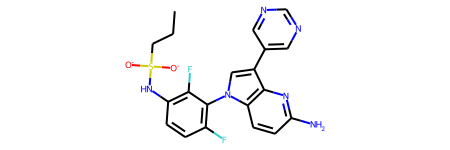

In [113]:
remote.coordinates.to_rdkit(12347, entity="ligand", extension="mol2")

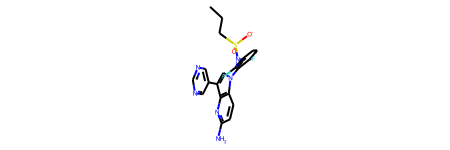

In [114]:
remote.coordinates.to_rdkit(12347, entity="ligand", extension="mol2", compute2d=False)

In [115]:
try:
    remote.coordinates.to_rdkit(12347, entity="ligand", extension="pdb")
except ValueError as e:
    print(e)

Entity ligand is not available or not available remotely.


### ... to `rdkit` molecule (locally)

#### ... from structure KLIFS ID

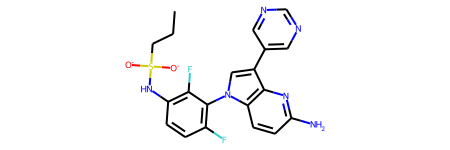

In [116]:
local.coordinates.to_rdkit(12347, entity="ligand", extension="mol2")

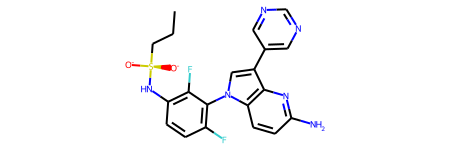

In [117]:
local.coordinates.to_rdkit(12347, entity="ligand", extension="pdb")

#### ... from file

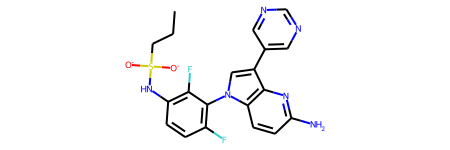

In [118]:
filepath = PATH_KLIFS_DOWNLOAD / "HUMAN/BRAF/6uuo_chainA/ligand.mol2"
local.coordinates.to_rdkit(filepath)

### ... to _mol2_ file (remotely)

In [119]:
filepath = remote.coordinates.to_mol2(12347, ".")
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN_BRAF_6uuo_chainA_complex.mol2 exists? True


In [120]:
filepath = remote.coordinates.to_mol2(12347, ".", entity="pocket")
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN_BRAF_6uuo_chainA_pocket.mol2 exists? True


In [121]:
filepath = remote.coordinates.to_mol2(12347, ".", entity="pocket", in_dir=True)
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN/BRAF/6uuo_chainA/pocket.mol2 exists? True


In [122]:
try:
    remote.coordinates.to_mol2(12347, ".", entity="bla")
except ValueError as e:
    print(e)

Entity bla is not available or not available remotely.


### ... to _pdb_ file (remotely)

In [123]:
filepath = remote.coordinates.to_pdb(12347, ".")
print(f"{filepath} exists? {filepath.exists()}")
filepath.unlink()
del filepath

HUMAN_BRAF_6uuo_chainA_complex.pdb exists? True


In [124]:
try:
    remote.coordinates.to_pdb(12347, ".", entity="ligand")
except ValueError as e:
    print(e)

Entity ligand is not available or not available remotely.
